In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
INITIAL_USERS = 500
MAX_USERS = 2000     # Maximum number of users
INITIAL_GOOD_RATIO = 0.8
TIMESTEPS = 500

# User join parameters
NEW_USERS_PER_STEP_MIN = 0
NEW_USERS_PER_STEP_MAX = 5
NEW_USER_GOOD_PROB = 0.7

In [16]:
rating_update_lr = 0.1  # alpha in the paper
quality_update_lr = 0.2  # eta in the paper

voting_cost = 0.01  # c in the paper

lambda_param = 0.1  # lambda in the paper

In [17]:
def post_display_probability(user_quality, post_ratings, lambda_param=0.1):
    """
    Calculate the probability of showing a post to a user based on quality and ratings.
    """
    numerator = np.exp(lambda_param * user_quality * post_ratings)
    denominator = np.sum(numerator)
    return numerator / denominator if denominator > 0 else np.ones_like(numerator) / len(numerator)

In [18]:
def post_rating_update(post_ratings, user_qualities, user_actions):
    """
    Update post ratings based on user interactions.
    """
    new_ratings = np.copy(post_ratings)
    
    for y in range(len(post_ratings)):
        interacted_users = np.where(user_actions[:, y] != 0)[0]
        
        if len(interacted_users) > 0:
            weighted_actions = np.sum(user_qualities[interacted_users] * user_actions[interacted_users, y])
            new_ratings[y] += rating_update_lr * weighted_actions
            
    return new_ratings

def user_quality_update(user_qualities, user_actions, post_ratings):
    """
    Update user qualities based on alignment with consensus.
    """
    new_qualities = np.copy(user_qualities)
    
    for y in range(len(post_ratings)):
        interacted_users = np.where(user_actions[:, y] != 0)[0]
        
        if len(interacted_users) > 0:
            weighted_actions = np.sum(user_qualities[interacted_users] * user_actions[interacted_users, y])
            
            for i in interacted_users:
                alignment = np.sign(user_actions[i, y] * weighted_actions)
                new_qualities[i] += quality_update_lr * alignment
    
    return new_qualities

In [19]:
def add_new_users(user_types, user_qualities, num_posts):
    """
    Add new users to the platform
    
    Parameters:
    - user_types: Array of user types (1 for good, 0 for bad)
    - user_qualities: Array of user qualities
    - num_posts: Number of posts for action initialization
    
    Returns:
    - Updated user_types and user_qualities
    """
    current_users = len(user_types)
    if current_users >= MAX_USERS:
        return user_types, user_qualities
    
    num_new_users = np.random.randint(NEW_USERS_PER_STEP_MIN, NEW_USERS_PER_STEP_MAX + 1)
    num_new_users = min(num_new_users, MAX_USERS - current_users)
    
    if num_new_users <= 0:
        return user_types, user_qualities
    
    new_user_types = np.random.random(num_new_users) < NEW_USER_GOOD_PROB
    new_user_types = new_user_types.astype(int)
    
    new_user_qualities = np.ones(num_new_users)
    
    updated_user_types = np.append(user_types, new_user_types)
    updated_user_qualities = np.append(user_qualities, new_user_qualities)
    
    return updated_user_types, updated_user_qualities

In [20]:
def simulate_platform():
    """
    Run a simulation of the content moderation platform with users joining over time
    """
    initial_good_users = int(INITIAL_USERS * INITIAL_GOOD_RATIO)
    initial_bad_users = INITIAL_USERS - initial_good_users

    user_types = np.array([1] * initial_good_users + [0] * initial_bad_users)
    user_qualities = np.ones(INITIAL_USERS)
    post_ratings = np.array([1.0, -1.0])
    
    rating_history = np.zeros((TIMESTEPS, 2))
    num_users_history = np.zeros(TIMESTEPS, dtype=int)
    good_ratio_history = np.zeros(TIMESTEPS)
    avg_good_quality_history = np.zeros(TIMESTEPS)
    avg_bad_quality_history = np.zeros(TIMESTEPS)
    
    for t in range(TIMESTEPS):
        current_users = len(user_qualities)
        num_good_users = np.sum(user_types)
        num_bad_users = current_users - num_good_users
        
        rating_history[t] = post_ratings
        num_users_history[t] = current_users
        good_ratio_history[t] = num_good_users / current_users if current_users > 0 else 0
        
        if num_good_users > 0:
            avg_good_quality_history[t] = np.mean(user_qualities[user_types == 1])
        if num_bad_users > 0:
            avg_bad_quality_history[t] = np.mean(user_qualities[user_types == 0])
        
        user_actions = np.zeros((current_users, 2))
        display_probs = np.array([post_display_probability(q, post_ratings, lambda_param) for q in user_qualities])

        for i in range(current_users):
            is_good_user = user_types[i] == 1
            for y in range(2):
                if np.random.random() < display_probs[i, y]:
                    if is_good_user:
                        user_actions[i, y] = 1 if y == 0 else -1  # Truthful voting
                    else:
                        user_actions[i, y] = -1 if y == 0 else 1  # Adversarial voting

        post_ratings = post_rating_update(post_ratings, user_qualities, user_actions)
        user_qualities = user_quality_update(user_qualities, user_actions, post_ratings)
        user_types, user_qualities = add_new_users(user_types, user_qualities, len(post_ratings))
    
    results = {
        'rating_history': rating_history,
        'num_users_history': num_users_history,
        'good_ratio_history': good_ratio_history,
        'avg_good_quality_history': avg_good_quality_history,
        'avg_bad_quality_history': avg_bad_quality_history,
        'final_user_types': user_types,
        'final_user_qualities': user_qualities
    }
    
    return results

In [21]:
results = simulate_platform()

rating_history = results['rating_history']
num_users_history = results['num_users_history']
good_ratio_history = results['good_ratio_history']
avg_good_quality_history = results['avg_good_quality_history']
avg_bad_quality_history = results['avg_bad_quality_history']
final_user_types = results['final_user_types']
final_user_qualities = results['final_user_qualities']


/tmp/ipykernel_1602676/155699955.py:5: RuntimeWarning: overflow encountered in exp
  numerator = np.exp(lambda_param * user_quality * post_ratings)
/tmp/ipykernel_1602676/155699955.py:7: RuntimeWarning: invalid value encountered in true_divide
  return numerator / denominator if denominator > 0 else np.ones_like(numerator) / len(numerator)


Text(0.5, 1.0, 'Post Ratings Over Time')

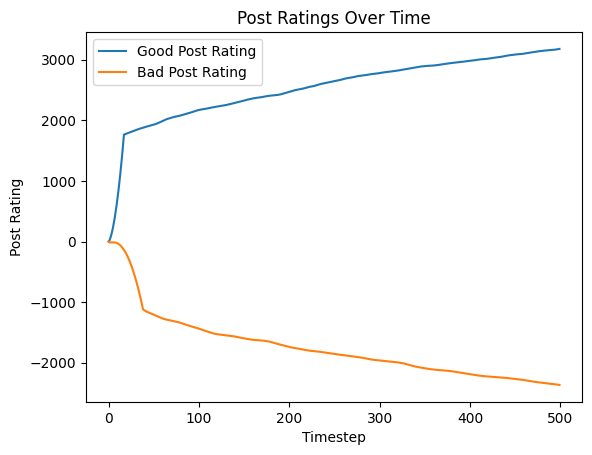

In [22]:
plt.plot(rating_history[:, 0], label='Good Post Rating')
plt.plot(rating_history[:, 1], label='Bad Post Rating')
plt.xlabel('Timestep')
plt.ylabel('Post Rating')
plt.legend()
plt.title('Post Ratings Over Time')

Text(0.5, 1.0, 'User Growth Over Time')

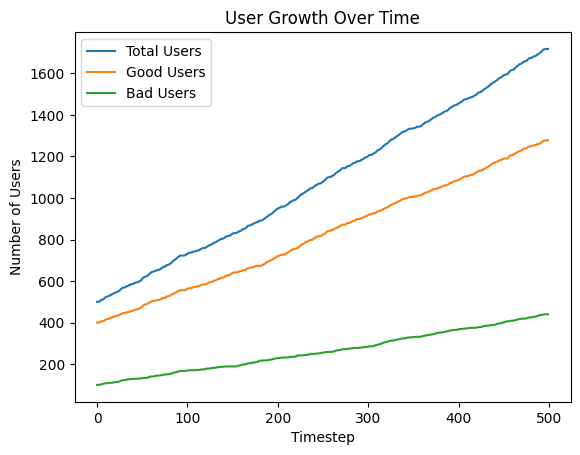

In [23]:
plt.plot(num_users_history, label='Total Users')
plt.plot(good_ratio_history * num_users_history, label='Good Users')
plt.plot(num_users_history * (1 - good_ratio_history), label='Bad Users')
plt.xlabel('Timestep')
plt.ylabel('Number of Users')
plt.legend()
plt.title('User Growth Over Time')

Text(0.5, 1.0, 'Ratio of Good Users Over Time')

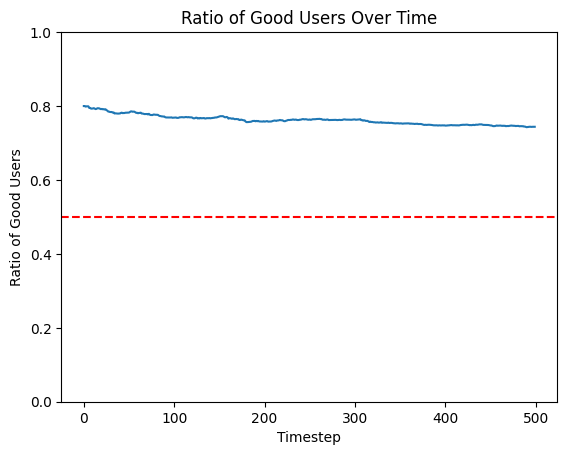

In [24]:
plt.plot(good_ratio_history)
plt.axhline(y=0.5, color='r', linestyle='--', label='50% Threshold')
plt.xlabel('Timestep')
plt.ylabel('Ratio of Good Users')
plt.ylim(0, 1)
plt.title('Ratio of Good Users Over Time')

Text(0.5, 1.0, 'Average User Qualities Over Time')

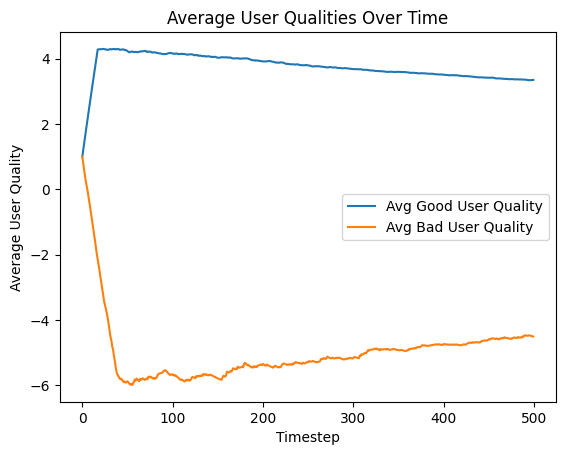

In [25]:
plt.plot(avg_good_quality_history, label='Avg Good User Quality')
plt.plot(avg_bad_quality_history, label='Avg Bad User Quality')
plt.xlabel('Timestep')
plt.ylabel('Average User Quality')
plt.legend()
plt.title('Average User Qualities Over Time')

Text(0.5, 1.0, 'Final Quality Distribution (Total: 1723 users)')

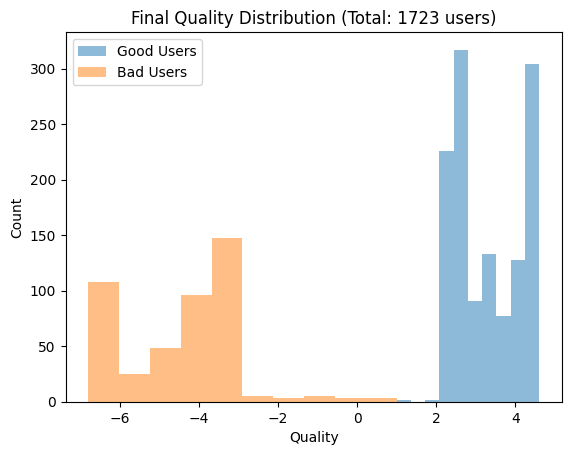

In [26]:
good_user_indices = np.where(final_user_types == 1)[0]
bad_user_indices = np.where(final_user_types == 0)[0]

if len(good_user_indices) > 0:
    plt.hist(final_user_qualities[good_user_indices], alpha=0.5, label='Good Users')
if len(bad_user_indices) > 0:
    plt.hist(final_user_qualities[bad_user_indices], alpha=0.5, label='Bad Users')

plt.xlabel('Quality')
plt.ylabel('Count')
plt.legend()
plt.title(f'Final Quality Distribution (Total: {len(final_user_qualities)} users)')